# Third Notebook: Senat Parse project - part A

List of potential ideas:
* calendar of intensity (long debates are red on a calendar)
* ratio of male to female in speakers
* early frequency analysis on intervention content

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ressources/senat_parse/complete_database/complete_debate_database.csv', sep=';', encoding='utf-8', index_col=0)

In [ ]:
df

,date,title,speaker_name,speaker_quality,speaker_link,speaker_intervention
0,2016-05-03,Séance du 3 mai 2016 (compte rendu intégral de...,M. le président.,NaN,/senateur/larcher_gerard86034e.html,(La séance est ouverte à quinze heures quinze.)
1,2016-05-03,Séance du 3 mai 2016 (compte rendu intégral de...,M. le président,NaN,/senateur/larcher_gerard86034e.html,Il n’y a pas d’observation ?…
2,2016-05-03,Séance du 3 mai 2016 (compte rendu intégral de...,M. le président.,NaN,/senateur/larcher_gerard86034e.html,"Avant de passer au scrutin, je vais donner la ..."
3,2016-05-03,Séance du 3 mai 2016 (compte rendu intégral de...,M. le président.,NaN,/senateur/larcher_gerard86034e.html,"La parole est à Mme Corinne Bouchoux, pour le ..."
4,2016-05-03,Séance du 3 mai 2016 (compte rendu intégral de...,Mme Corinne Bouchoux.,NaN,/senateur/bouchoux_corinne11029k.html,"Sur la base d’une méthode originale, les avis ..."
...,...,...,...,...,...,...
20,2008-01-09,Séance du 9 janvier 2008 (compte rendu intégra...,"Mme Christine Lagarde,",ministre.,NaN,"Le troisième constat, c'est que la voie du « r..."
21,2008-01-09,Séance du 9 janvier 2008 (compte rendu intégra...,"M. Nicolas About,",président de la commission des affaires sociales.,/senfic/about_nicolas95004y.html,"M. Nicolas About, président de la commission d..."
22,2008-01-09,Séance du 9 janvier 2008 (compte rendu intégra...,"Mme Christine Lagarde,",ministre.,NaN,Tout cela doit permettre de mettre en place ra...
23,2008-01-09,Séance du 9 janvier 2008 (compte rendu intégra...,M. le président.,NaN,/senfic/gouteyron_adrien78006d.html,M. le président. La parole est à Mme le rappor...


# Sex extraction

`M.` stands for "Mister" and `Mme` stands for "Madam". We can create a "sex" column to identify the speaker gender.

`isFemale` is a pseudo-boolean variable:
* 0 = False, one man
* 1 = True, one woman
* 2 = True, but one woman and one man

Women are present in all interventions with a value 1 and 2. Men are prensent in all interventions with a value 0 and 2.

For the next steps, we will remove groups with values different from 0 and 1 to get less biased data. 

In [ ]:
set(df.head(10).speaker_name.unique())

{'M. Bruno Sido,',
 'M. Hubert Falco.',
 'M. le président',
 'M. le président.',
 'Mme Corinne Bouchoux.'}

In [ ]:
df['isFemale'] = ((df.speaker_name.str.contains('M.', case=True, regex=False) * 1) +  (df.speaker_name.str.contains('Mme', case=True, regex=False) * 2) - 1)

In [ ]:
df_sex = df[(df['isFemale'] == 0) | (df['isFemale'] == 1)]

In [ ]:
df_sex

,date,title,speaker_name,speaker_quality,speaker_link,speaker_intervention,isFemale
0,2016-05-03,Séance du 3 mai 2016 (compte rendu intégral de...,M. le président.,NaN,/senateur/larcher_gerard86034e.html,(La séance est ouverte à quinze heures quinze.),0
1,2016-05-03,Séance du 3 mai 2016 (compte rendu intégral de...,M. le président,NaN,/senateur/larcher_gerard86034e.html,Il n’y a pas d’observation ?…,0
2,2016-05-03,Séance du 3 mai 2016 (compte rendu intégral de...,M. le président.,NaN,/senateur/larcher_gerard86034e.html,"Avant de passer au scrutin, je vais donner la ...",0
3,2016-05-03,Séance du 3 mai 2016 (compte rendu intégral de...,M. le président.,NaN,/senateur/larcher_gerard86034e.html,"La parole est à Mme Corinne Bouchoux, pour le ...",0
4,2016-05-03,Séance du 3 mai 2016 (compte rendu intégral de...,Mme Corinne Bouchoux.,NaN,/senateur/bouchoux_corinne11029k.html,"Sur la base d’une méthode originale, les avis ...",1
...,...,...,...,...,...,...,...
20,2008-01-09,Séance du 9 janvier 2008 (compte rendu intégra...,"Mme Christine Lagarde,",ministre.,NaN,"Le troisième constat, c'est que la voie du « r...",1
21,2008-01-09,Séance du 9 janvier 2008 (compte rendu intégra...,"M. Nicolas About,",président de la commission des affaires sociales.,/senfic/about_nicolas95004y.html,"M. Nicolas About, président de la commission d...",0
22,2008-01-09,Séance du 9 janvier 2008 (compte rendu intégra...,"Mme Christine Lagarde,",ministre.,NaN,Tout cela doit permettre de mettre en place ra...,1
23,2008-01-09,Séance du 9 janvier 2008 (compte rendu intégra...,M. le président.,NaN,/senfic/gouteyron_adrien78006d.html,M. le président. La parole est à Mme le rappor...,0


In [ ]:
df_sex.date.describe()

count         110498
unique          2163
top       2006-12-11
freq            1212
Name: date, dtype: object

In [ ]:
df_sex.isFemale.describe()

count     110498
unique         2
top            0
freq       88446
Name: isFemale, dtype: int64

In [ ]:
df_sex

,date,title,speaker_name,speaker_quality,speaker_link,speaker_intervention,isFemale
0,2016-05-03,Séance du 3 mai 2016 (compte rendu intégral de...,M. le président.,NaN,/senateur/larcher_gerard86034e.html,(La séance est ouverte à quinze heures quinze.),0
1,2016-05-03,Séance du 3 mai 2016 (compte rendu intégral de...,M. le président,NaN,/senateur/larcher_gerard86034e.html,Il n’y a pas d’observation ?…,0
2,2016-05-03,Séance du 3 mai 2016 (compte rendu intégral de...,M. le président.,NaN,/senateur/larcher_gerard86034e.html,"Avant de passer au scrutin, je vais donner la ...",0
3,2016-05-03,Séance du 3 mai 2016 (compte rendu intégral de...,M. le président.,NaN,/senateur/larcher_gerard86034e.html,"La parole est à Mme Corinne Bouchoux, pour le ...",0
4,2016-05-03,Séance du 3 mai 2016 (compte rendu intégral de...,Mme Corinne Bouchoux.,NaN,/senateur/bouchoux_corinne11029k.html,"Sur la base d’une méthode originale, les avis ...",1
...,...,...,...,...,...,...,...
20,2008-01-09,Séance du 9 janvier 2008 (compte rendu intégra...,"Mme Christine Lagarde,",ministre.,NaN,"Le troisième constat, c'est que la voie du « r...",1
21,2008-01-09,Séance du 9 janvier 2008 (compte rendu intégra...,"M. Nicolas About,",président de la commission des affaires sociales.,/senfic/about_nicolas95004y.html,"M. Nicolas About, président de la commission d...",0
22,2008-01-09,Séance du 9 janvier 2008 (compte rendu intégra...,"Mme Christine Lagarde,",ministre.,NaN,Tout cela doit permettre de mettre en place ra...,1
23,2008-01-09,Séance du 9 janvier 2008 (compte rendu intégra...,M. le président.,NaN,/senfic/gouteyron_adrien78006d.html,M. le président. La parole est à Mme le rappor...,0


## Number of women per day of the week

In [ ]:
# get day of the week feature
df_sex['date'] = pd.to_datetime(df_sex.date)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### All the interventions

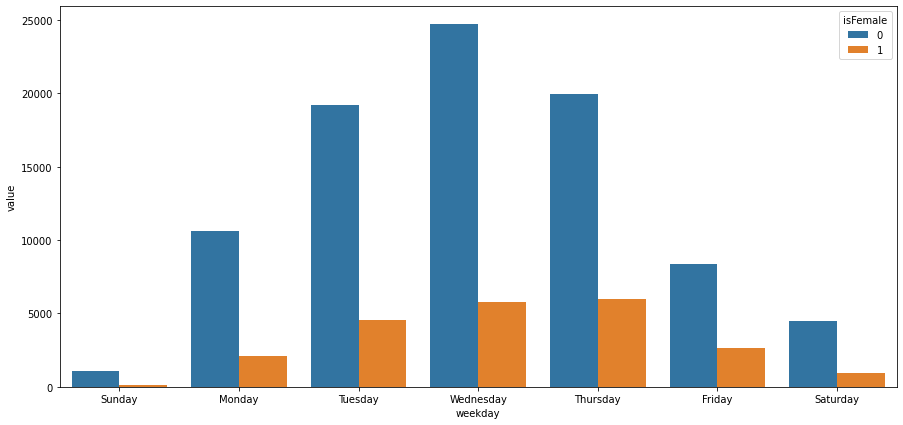

In [ ]:
def from_df_to_compared_bar_graph(df):
  df_sex_by_day = df.copy()
  df_sex_by_day['weekday'] = df_sex_by_day.date.dt.day_name()
  df_sex_by_day_to_plot = df_sex_by_day[['isFemale', 'weekday']].pivot_table(index='weekday', columns='isFemale', aggfunc='size')
  df_sex_by_day_to_plot = df_sex_by_day_to_plot.reset_index()
  # df_sex_by_day_to_plot.head()

  df_sex_by_day_to_return = df_sex_by_day_to_plot

  df_sex_by_day_to_plot = df_sex_by_day_to_plot.melt(id_vars='weekday')
  # df_sex_by_day_to_plot.head()
  plt.figure(figsize=[15,7])
  order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

  sns.barplot(data=df_sex_by_day_to_plot, x="weekday", y="value", hue="isFemale", order=order)
  plt.show()

  return df_sex_by_day_to_return

all_interventions_df = from_df_to_compared_bar_graph(df_sex)

### What happens if we remove the director ?

"M. le président." is a recurrent role and is occupied by a man. If we remove all occurences, we will then measure the diversity in terms of invited speakers rather than diversity including the debates host. 

In [ ]:
df_sex['is_president'] = df_sex['speaker_name'].str.contains('président', regex=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


40% of the interventions are due to the debate director:

In [ ]:
df_sex.is_president.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

False    60.4%
True     39.6%
Name: is_president, dtype: object

In [ ]:
df_without_director = df_sex[df_sex['is_president'] == False]

We get a less biased situation: 

* as many women interventions as before
* many less men interventions (-40%)

=> improved disparity ratio. Still a large gap between the two.

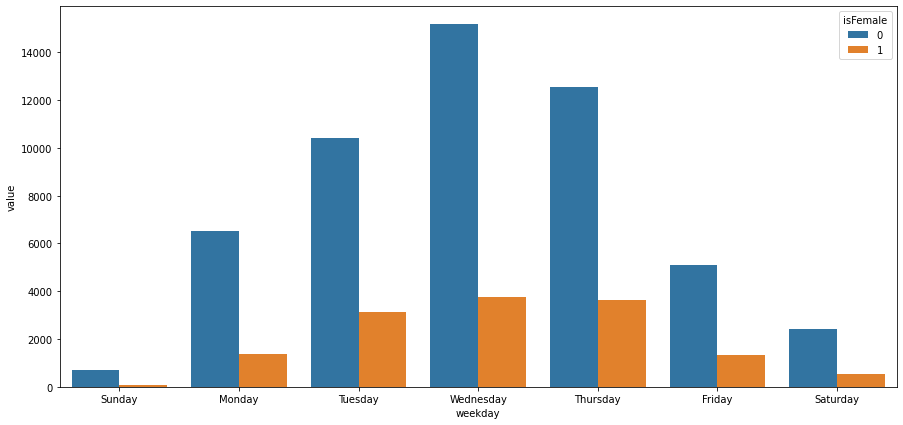

In [ ]:
without_director_df = from_df_to_compared_bar_graph(df_without_director)

### What happens when we check unique speakers per day ?

Maybe women participate often in debates but have a low number of interventions.  
Lets look the number of women and men per debate, and see if ratios change.

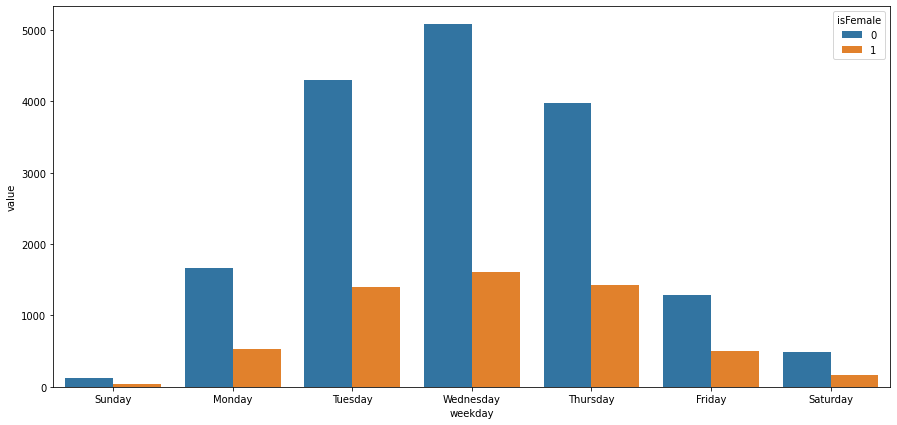

In [ ]:
def from_df_to_compared_bar_graph_count(df):
  df_sex_by_day = df.copy()
  df_sex_by_day['weekday'] = df_sex_by_day.date.dt.day_name()
  df_sex_by_day = df_sex_by_day[['isFemale', 'weekday', 'speaker_name', 'date']].drop_duplicates()
  df_sex_by_day_to_plot = df_sex_by_day[['isFemale', 'weekday']].pivot_table(index='weekday', columns='isFemale', aggfunc='size')
  df_sex_by_day_to_plot = df_sex_by_day_to_plot.reset_index()
  # df_sex_by_day_to_plot.head()

  df_sex_by_day_to_return = df_sex_by_day_to_plot

  df_sex_by_day_to_plot = df_sex_by_day_to_plot.melt(id_vars='weekday')
  # df_sex_by_day_to_plot.head()

  plt.figure(figsize=[15,7])
  order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

  sns.barplot(data=df_sex_by_day_to_plot, x="weekday", y="value", hue="isFemale", order=order)
  plt.show()

  return df_sex_by_day_to_return

participation_df = from_df_to_compared_bar_graph_count(df_sex)

We see that women are in fact invited to most debates.  

However, their participation seems to be significantly lower on Tuesday, Wednesday, and Thursday: the 3 most important days. 
The rest of the week, we can't see any major change.  

### Compare 3 methods in terms of sex ratios

In [ ]:
all_interventions_df['type'] = 'all_interventions'
without_director_df['type'] = 'without_director'
participation_df['type'] = 'participation'

compare_df = pd.concat([all_interventions_df, without_director_df, participation_df])
compare_df.columns = ['weekday', 'male', 'female', 'type']
compare_df['female_ratio'] = compare_df['female'] / compare_df['male'] * 100
compare_df['male_ratio'] = 100 - compare_df['female_ratio']
compare_df.reset_index(drop=True, inplace=True)
compare_df['weekday'] = pd.Categorical(compare_df['weekday'], categories=
    ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'],
    ordered=True)

In [ ]:
compare_df

,weekday,male,female,type,female_ratio,male_ratio
0,Friday,8387,2632,all_interventions,31.381901,68.618099
1,Monday,10652,2104,all_interventions,19.752159,80.247841
2,Saturday,4456,926,all_interventions,20.780969,79.219031
3,Sunday,1061,116,all_interventions,10.933082,89.066918
4,Thursday,19992,5984,all_interventions,29.931973,70.068027
5,Tuesday,19187,4525,all_interventions,23.583676,76.416324
6,Wednesday,24711,5765,all_interventions,23.329691,76.670309
7,Friday,5112,1335,without_director,26.115023,73.884977
8,Monday,6535,1352,without_director,20.688600,79.311400
9,Saturday,2402,542,without_director,22.564530,77.435470


We can see that the "participation" type (not related to the number of interventions) has the most favorable outcomes in terms of female parity. 

Then comes the "without director" type, with large gains on Tuesday but a loss on the last days of the week.  

Finally, the "all interventions" type, which is only better than "without director" on Thursday and Friday. 

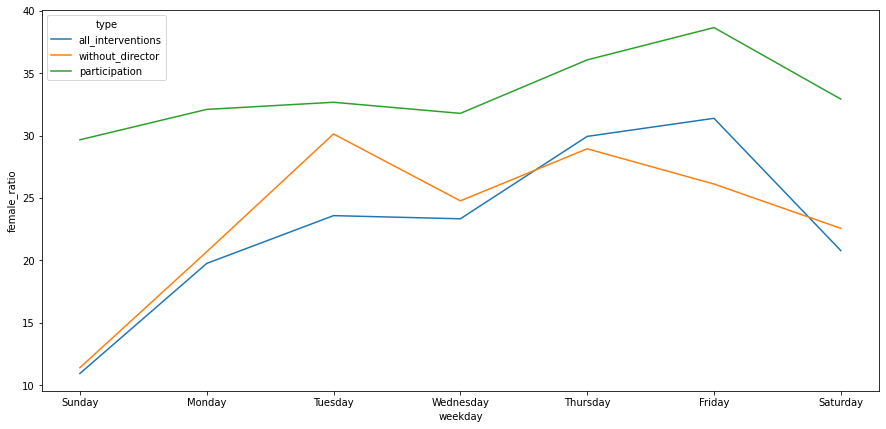

In [ ]:
plt.figure(figsize=[15,7])
sns.lineplot(data=compare_df, x='weekday', y='female_ratio', hue='type')
plt.show()

## Women ratio per debate on calendars

### demo calendar lib

In [ ]:
!pip install calplot

(<Figure size 900x244.8 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f513fa7af10>,
       dtype=object))

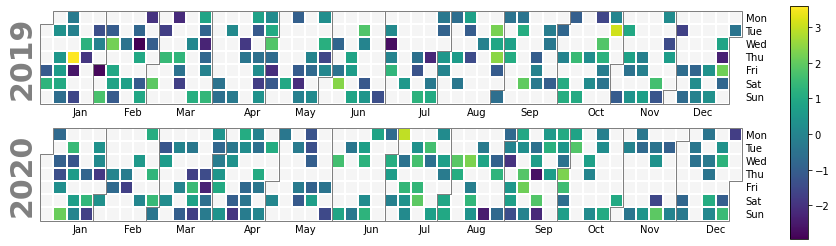

In [ ]:
import calplot
import numpy as np; np.random.seed(sum(map(ord, 'calplot')))
import pandas as pd
all_days = pd.date_range('1/1/2019', periods=730, freq='D')
days = np.random.choice(all_days, 500)
events = pd.Series(np.random.randn(len(days)), index=days)
calplot.calplot(events)

In [ ]:
events

2020-07-27    0.177954
2019-06-16    0.860401
2019-11-03   -1.058042
2019-12-27    0.169200
2019-12-27    1.368074
                ...   
2019-11-05    0.959122
2020-09-07    0.206982
2020-03-15    0.419696
2020-04-26    0.041664
2019-01-30   -0.071506
Length: 500, dtype: float64

### raw dataset for benchmark

The raw dates from input dataset are presented in calendars from 2001 to 2022.  
The amount of availiable data is maximal in this case. Any filters removing debates from the dataset will remove squares from the calendars.


(<Figure size 720x2448 with 20 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f513d907c50>,
       dtype=object))

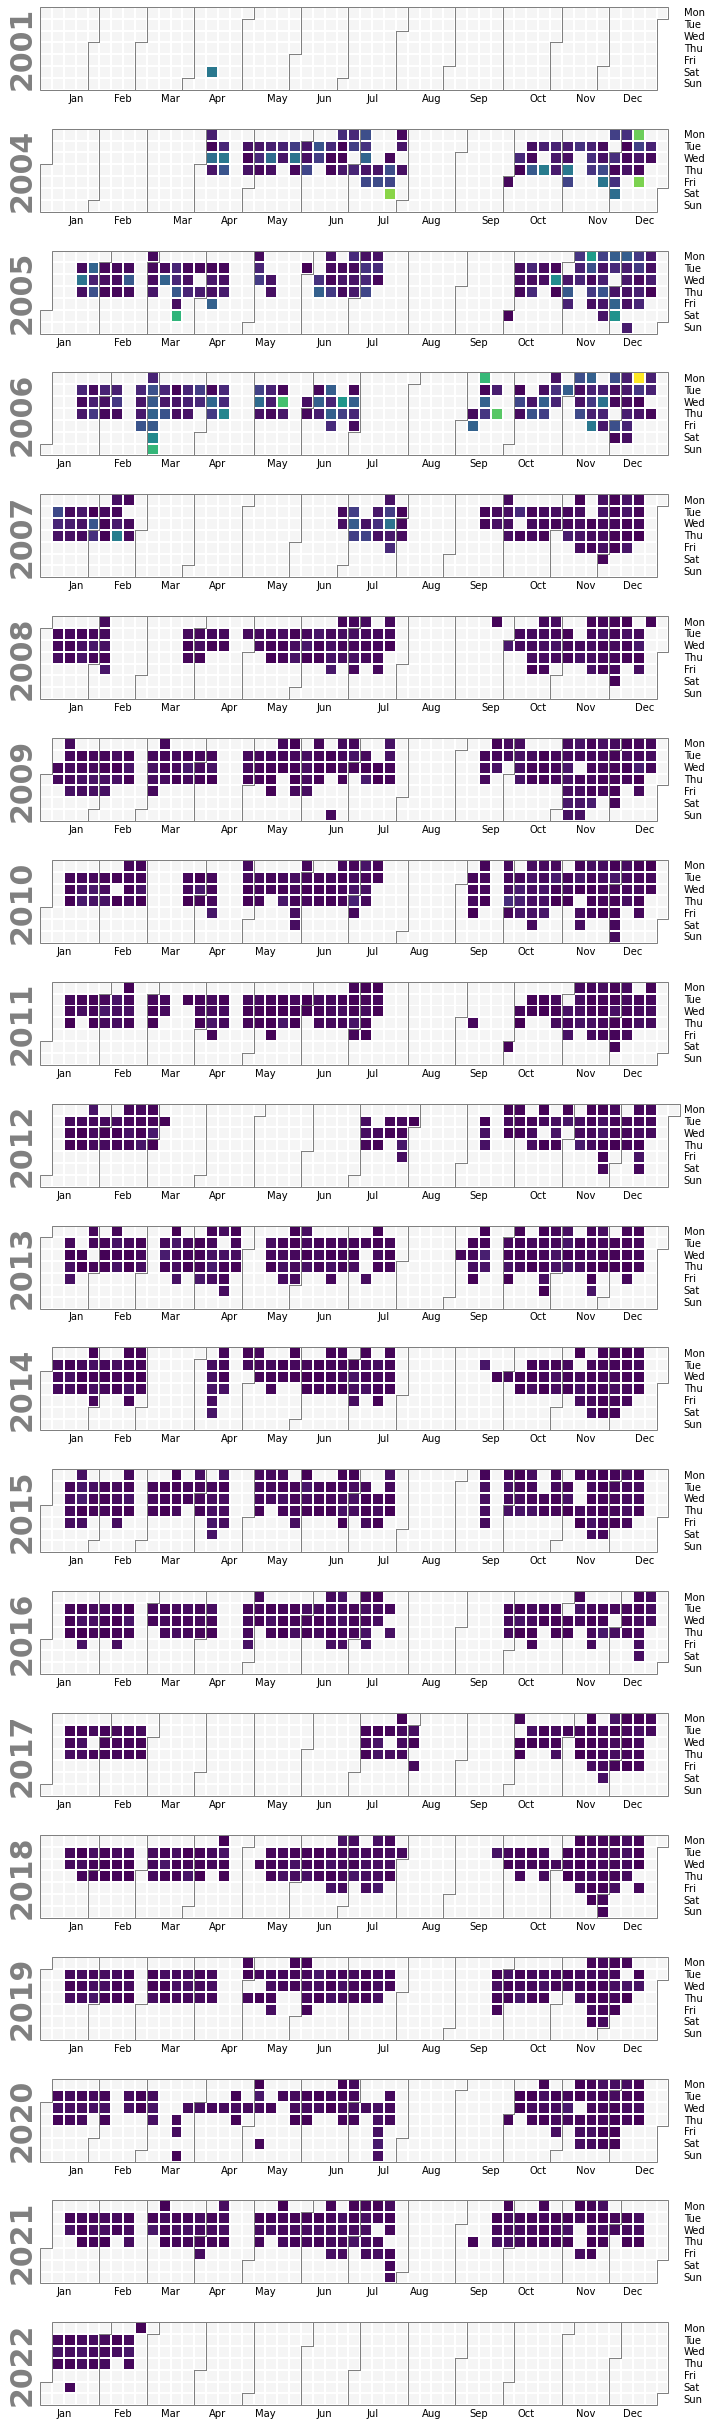

In [ ]:
df_test = df.copy()
df_test['unity'] = 1
df_test = df_test[['date', 'unity']].copy()


df_test['date'] = pd.to_datetime(df_test.date)

events = pd.Series(list(df_test.unity), index=list(df_test.date))
calplot.calplot(events)

### dataset for calendar

In [ ]:
calendar_df = df_sex.copy()

In [ ]:
calendar_df = calendar_df[['date', 'isFemale']].copy()
calendar_df
calendar__long_df = calendar_df.pivot_table(index='date', columns=['isFemale'], aggfunc='size')
calendar__long_df.reset_index(inplace=True)
calendar__long_df.columns = ['date', 'men_count', 'women_count']
calendar__long_df.fillna(0, inplace=True)
calendar__long_df['women_ratio'] = calendar__long_df['women_count'] / (calendar__long_df['men_count'] + calendar__long_df['women_count']) * 100
calendar__long_df[['date', 'women_ratio']]

,date,women_ratio
0,2001-04-14,3.586498
1,2004-04-05,28.571429
2,2004-04-06,5.882353
3,2004-04-07,12.235294
4,2004-04-08,7.462687
...,...,...
2158,2022-02-09,18.421053
2159,2022-02-15,34.375000
2160,2022-02-16,32.352941
2161,2022-02-17,4.000000


In [ ]:
calendar__long_df

,date,men_count,women_count,women_ratio
0,2001-04-14,457.0,17.0,3.586498
1,2004-04-05,75.0,30.0,28.571429
2,2004-04-06,16.0,1.0,5.882353
3,2004-04-07,373.0,52.0,12.235294
4,2004-04-08,62.0,5.0,7.462687
...,...,...,...,...
2158,2022-02-09,31.0,7.0,18.421053
2159,2022-02-15,21.0,11.0,34.375000
2160,2022-02-16,46.0,22.0,32.352941
2161,2022-02-17,24.0,1.0,4.000000


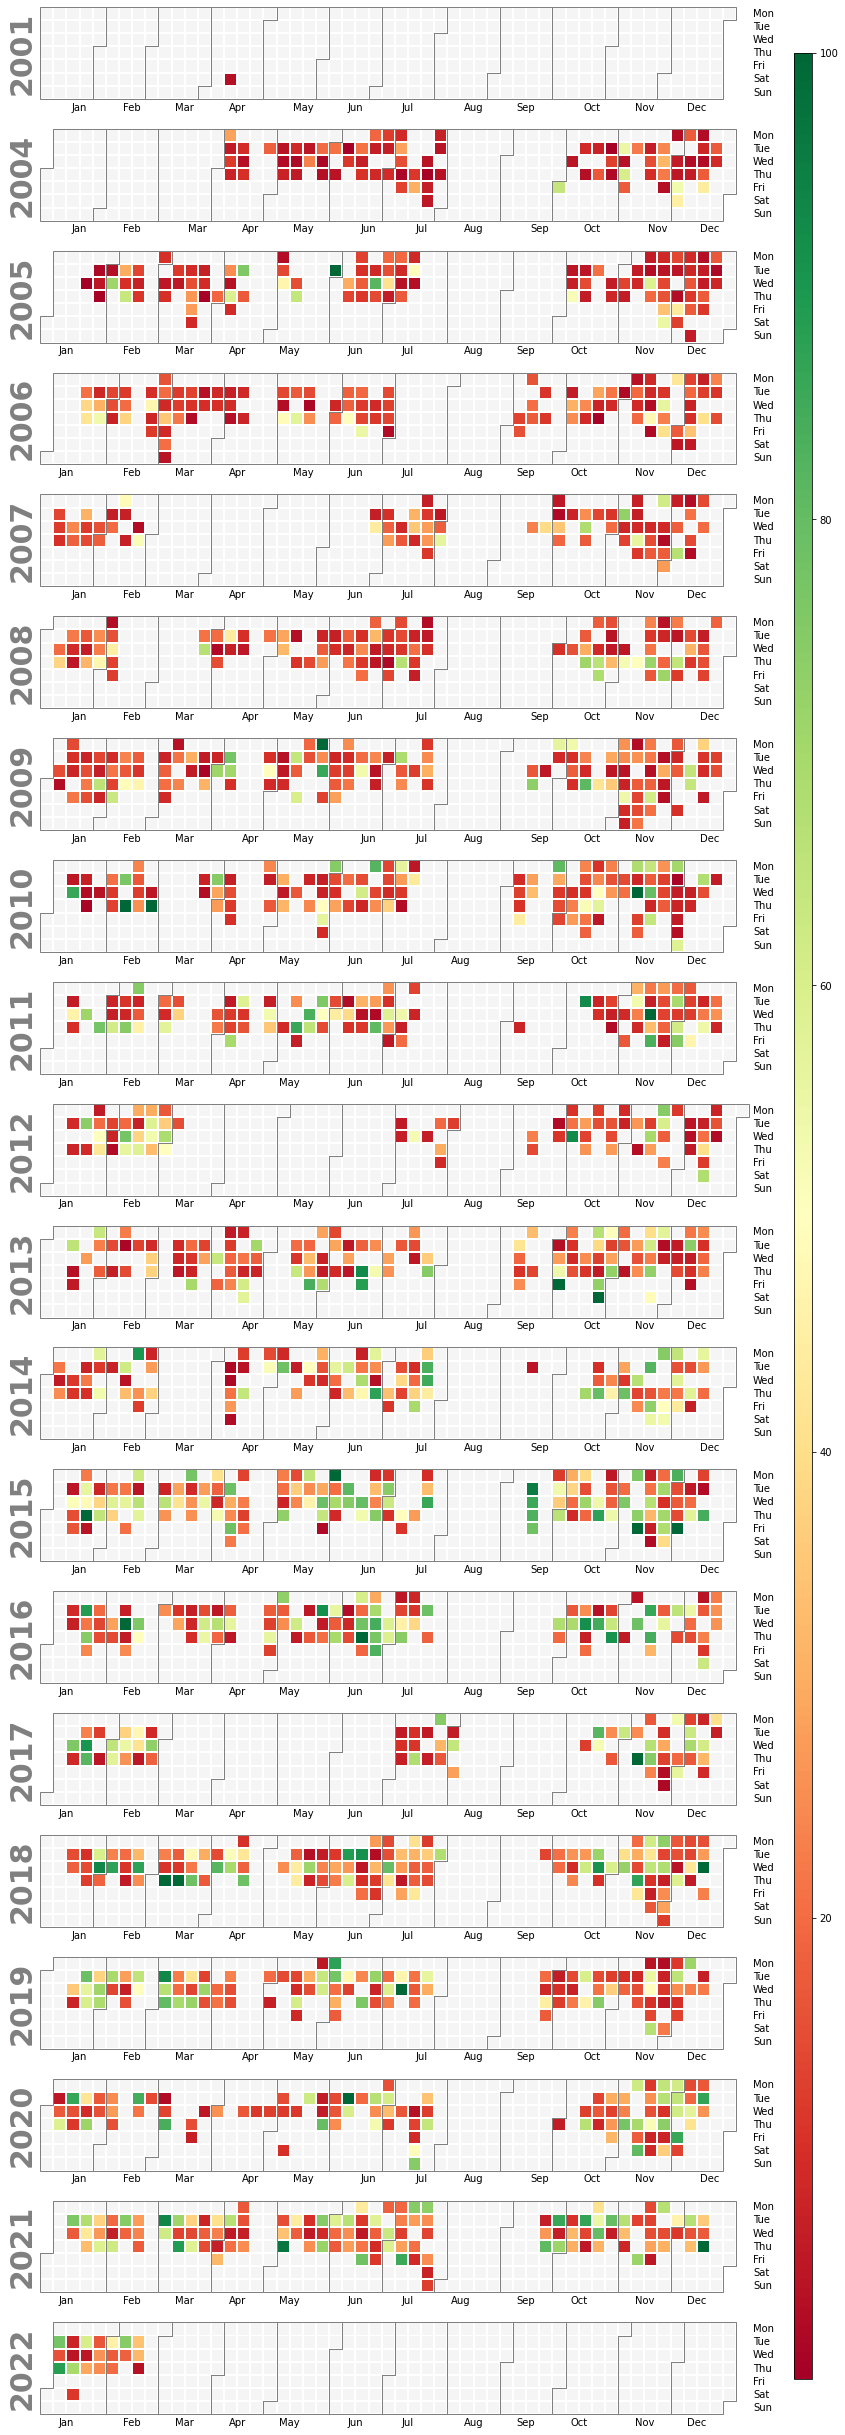

In [ ]:
events = pd.Series(list(calendar__long_df.women_ratio), index=list(calendar__long_df.date))
calplot.calplot(events, cmap='RdYlGn')
plt.show()

### Men and women count barplots

We can observe a difference in men and women attendance: men seem to be more numerous more often.

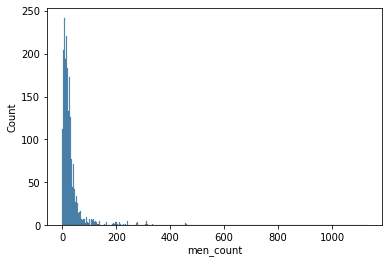

In [ ]:
sns.histplot(data=calendar__long_df, x='men_count')

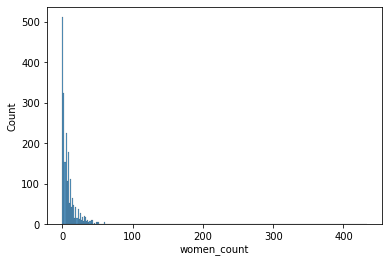

In [ ]:
sns.histplot(data=calendar__long_df, x='women_count')

If we split the participation of men and women into 10 deciles and ignore the first and last (as they only represent 20% of the dataset with exotic cases), we find that women are more likely to be in low attendance numbers compared to men. 

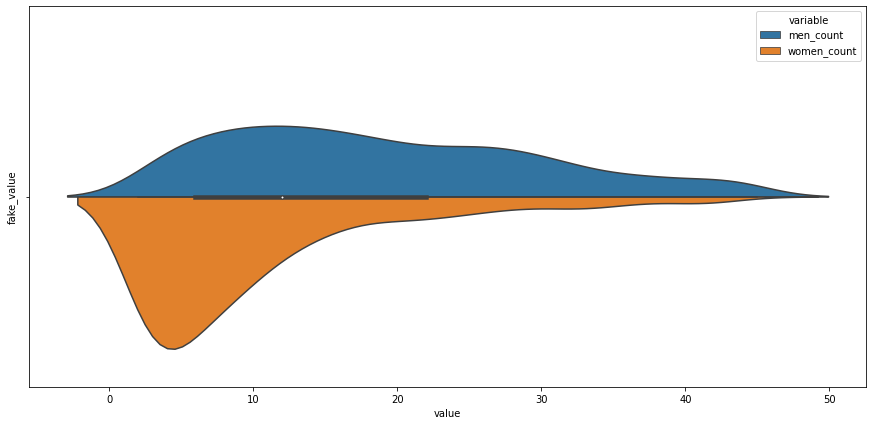

In [ ]:
violin_plot_df = calendar__long_df[['men_count', 'women_count']].melt()
bin_number = 10
violin_plot_df['quantile'] = pd.qcut(violin_plot_df.value, bin_number, labels=range(1,bin_number+1))

violin_plot_df = violin_plot_df[(violin_plot_df['quantile'] < 10) & (violin_plot_df['quantile'] > 1)]

violin_plot_df['value'] = violin_plot_df.value.astype(int)
violin_plot_df['fake_value'] = ""
plt.figure(figsize=[15,7])
sns.violinplot(data=violin_plot_df, hue='variable', x='value', y='fake_value', split=True)
plt.show()

### Absolute number of women per year

Given that the number of women present in a year varies around a very narrow bell shape, we should set that value to be the center of our scale. 

Given the previous violin plot, the middle value sould be 5: if more than 5 women are present, it is more than the median. If less, then it is a bad day.
Below is a quick line that shows that the actual median value for women is 7 so we will use this one (remember: the 1st and 10th quantiles are removed on the graph above, as well as in the dataset used below).

In [ ]:
violin_plot_df[violin_plot_df['variable'] == 'women_count'].value.describe()

count    1593.000000
mean       10.520402
std         9.176165
min         2.000000
25%         4.000000
50%         7.000000
75%        13.000000
max        45.000000
Name: value, dtype: float64

In [ ]:
violin_plot_df[violin_plot_df['variable'] == 'women_count'].value.describe()

count    1593.000000
mean       10.520402
std         9.176165
min         2.000000
25%         4.000000
50%         7.000000
75%        13.000000
max        45.000000
Name: value, dtype: float64

In [ ]:
#misleading figure -- plot only to understand the ceiling method used when defining the custom scale

# # calendar__long_df
# events = pd.Series(list(calendar__long_df.women_count), index=list(calendar__long_df.date))

# from matplotlib import colors
# describe_set = calendar__long_df.women_count.describe()
# divnorm = colors.TwoSlopeNorm(vmin=describe_set['min'], vcenter=describe_set['50%'], vmax=describe_set['max'])

# calplot.calplot(events, cmap='RdYlGn', norm=divnorm)
# plt.show()

Recentering is still hard to see because the maximum values are so high and so few that they flatten the scale. We should cap all values to 50 so we can get a better view

In [ ]:
calendar__long_df.loc[calendar__long_df.women_count > 50, 'women_count'] = 50


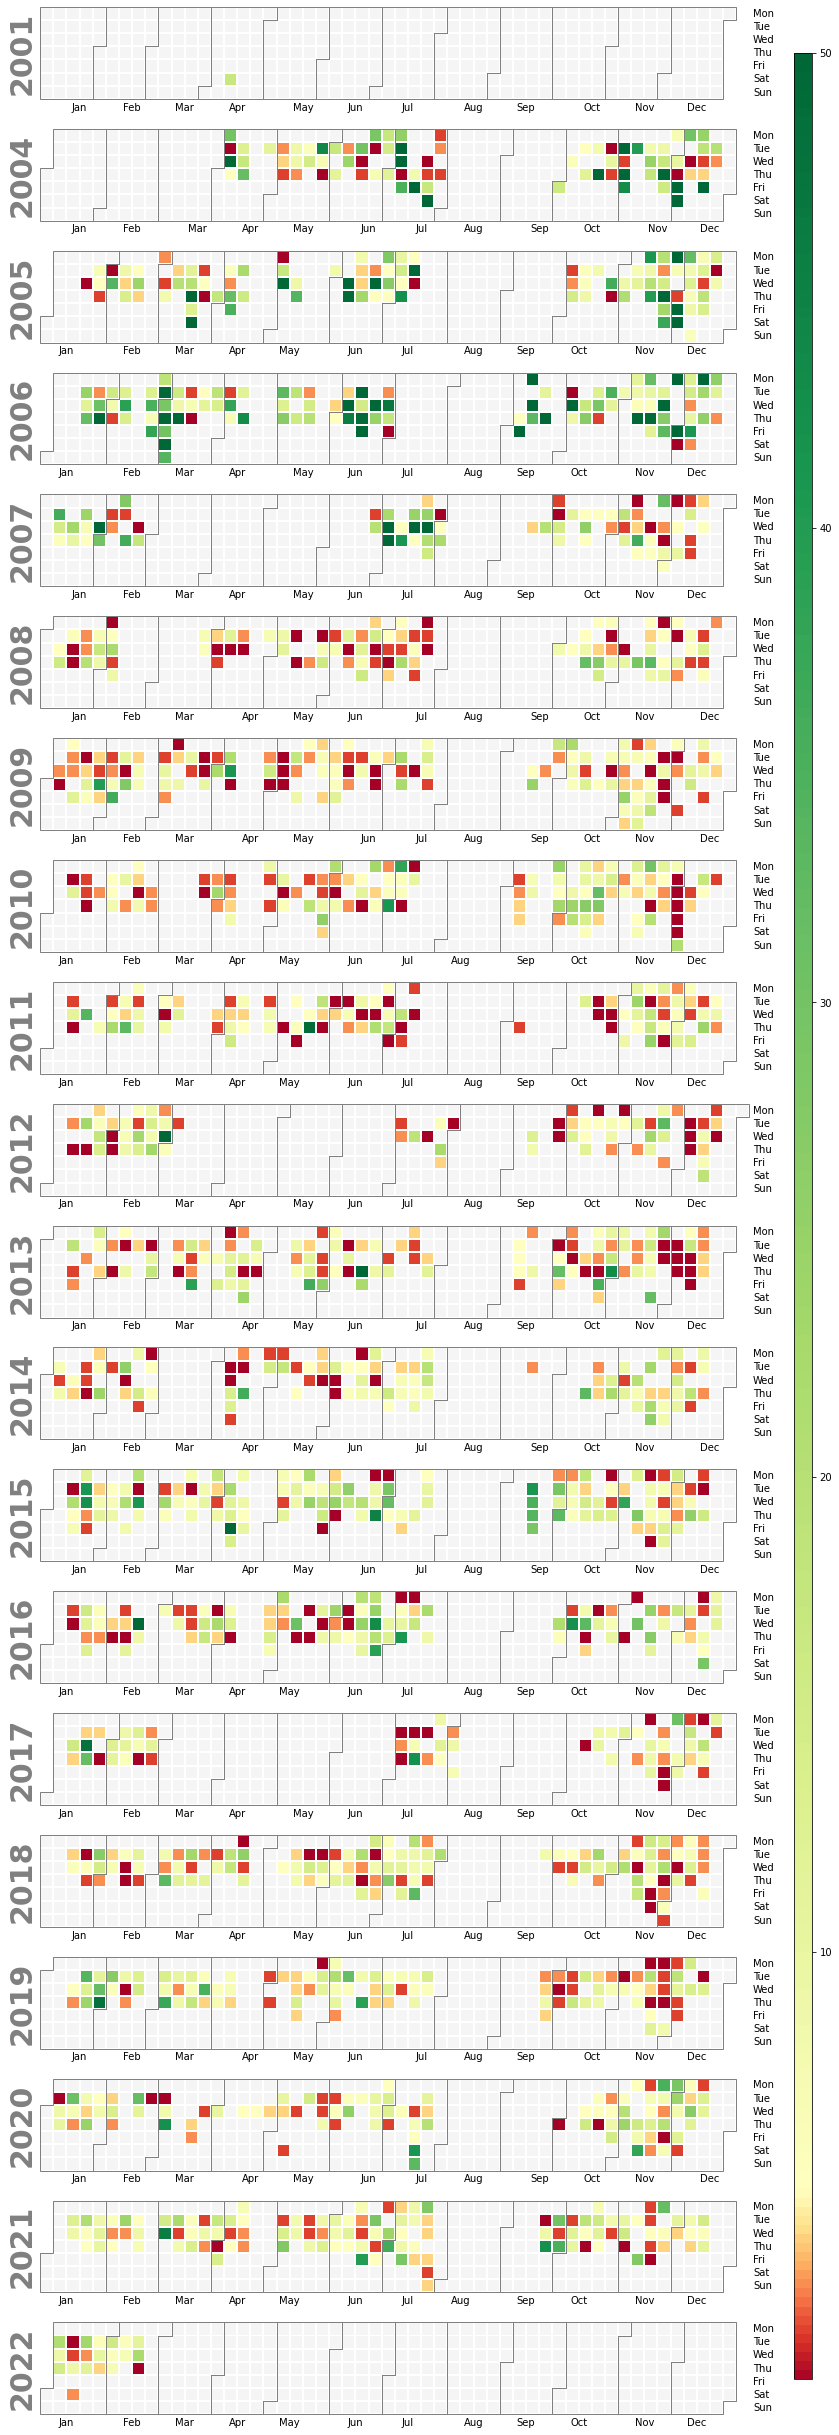

In [ ]:
# calendar__long_df
events = pd.Series(list(calendar__long_df.women_count), index=list(calendar__long_df.date))

from matplotlib import colors
describe_set = calendar__long_df.women_count.describe()
divnorm = colors.TwoSlopeNorm(vmin=describe_set['min'], vcenter=describe_set['50%'], vmax=describe_set['max'])

calplot.calplot(events, cmap='RdYlGn', norm=divnorm)
plt.show()

# TODO:Women before and after renewal

Half the senate is replaced every 3 years, thus giving each senator 6 year to execture their mandate. This means that every 3 year, women have an oppportunity to enter.  
Does the women ratio vary significantly form election to election ? 

Here are the know election dates:
* 23 sept 2001
* 26 sept 2004
* 21 sept 2008 (report due to 2007 loaded year)
* 25 sept 2011
* 28 sept 2014
* 24 sept 2017
* 27 sept 2020
* 2023: TBD

In [ ]:
election_date_list = [
                      '2001-09-23',
                      '2004-09-26',
                      '2008-09-21',
                      '2011-09-25',
                      '2014-09-28',
                      '2017-09-24',
                      '2020-09-27'
]

In [ ]:
election_date_list

['2001-09-23',
 '2004-09-26',
 '2008-09-21',
 '2011-09-25',
 '2014-09-28',
 '2017-09-24',
 '2020-09-27']

TODO: find a way to extract custom date ranges without doing it manually for each and every generation.

# Next notebook: Nobliity analysis

https://colab.research.google.com/drive/15r4hLkxnfzTjRpMP9Y0_NXEQBqsqLYeM#scrollTo=WdFFVOuNHizV 